In [1]:
import numpy as np
import pandas as pd
# from tqdm import tqdm_notebook
import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from matplotlib import pyplot as plt
# import librosa
# import librosa.display

## Загрузка данных

In [2]:
col_names = ['time', 'emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'pot_1', 'pot_2', 'pot_3']
data = pd.read_csv('V_free_sgib_rasg_fast_NEW.csv', sep=';', header=None, names=col_names)

In [3]:
data = data[:26000]
data

,time,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,pot_1,pot_2,pot_3
0,0.00,1650.81,1676.60,1676.60,1676.60,1676.60,1676.60,154.85,102.54,104.00
1,0.00,1654.03,1650.81,1650.81,1650.81,1650.81,1650.81,154.85,102.54,104.00
2,0.01,1657.25,1615.34,1615.34,1615.34,1615.34,1615.34,154.85,102.54,104.00
3,0.01,1654.03,1573.42,1573.42,1573.42,1573.42,1573.42,154.85,102.54,104.00
4,0.01,1650.81,1554.08,1554.08,1554.08,1554.08,1554.08,154.85,102.54,104.00
...,...,...,...,...,...,...,...,...,...,...
25995,51.99,1628.24,1647.58,1647.58,1647.58,1647.58,1647.58,29.56,18.46,18.16
25996,51.99,1625.01,1647.58,1647.58,1647.58,1647.58,1647.58,29.56,18.46,18.16
25997,52.00,1637.91,1654.03,1654.03,1654.03,1654.03,1654.03,29.56,18.46,18.16
25998,52.00,1631.46,1660.48,1660.48,1660.48,1660.48,1660.48,29.56,18.46,18.16


In [4]:
data[['pot_2', 'pot_3']] = data[['pot_2', 'pot_3']].astype(float)

In [5]:
data.dtypes

time     float64
emg_1    float64
emg_2    float64
emg_3    float64
emg_4    float64
emg_5    float64
emg_6    float64
pot_1    float64
pot_2    float64
pot_3    float64
dtype: object

# Data preprocessing

Нормализация

In [6]:
data = (data - data.mean()) / data.std()

Чистим данные

In [7]:
data = data[['emg_1', 'emg_2', 'pot_1']]
data

,emg_1,emg_2,pot_1
0,0.063537,0.154306,1.022798
1,0.236421,0.006507,1.022798
2,0.409305,-0.196766,1.022798
3,0.236421,-0.437003,1.022798
4,0.063537,-0.547838,1.022798
...,...,...,...
25995,-1.148262,-0.012003,-1.417608
25996,-1.321682,-0.012003,-1.417608
25997,-0.629073,0.024960,-1.417608
25998,-0.975378,0.061924,-1.417608


Создание датасета

In [8]:
x_size = 50
y_size = 50

def create_sequences(values, x_size, y_size):
    print(len(values))
    X_output = []
    Y_output = []
    for i in range(0, len(values)-y_size, x_size): # + y_size
        X_output.append(values[i : (i + x_size)])
        Y_output.append(values[(i + x_size) : (i + x_size + y_size)])
#     print(len(X_output[0]), len(Y_output[519]))
    return torch.FloatTensor(X_output).permute(0, 2, 1), torch.FloatTensor(Y_output).permute(0, 2, 1)
#     return torch.from_numpy(np.array(X_output)).to(torch.float32).permute(0, 2, 1), torch.from_numpy(np.array(Y_output)).to(torch.float32).permute(0, 2, 1)


X, Y = create_sequences(data.values, x_size, y_size)
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, shuffle=False)
print("Training x input shape: ", x_train.shape)
print("Training y input shape: ", y_train.shape)
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=6, shuffle=False)

26000
Training x input shape:  torch.Size([467, 3, 50])
Training y input shape:  torch.Size([467, 3, 50])


<ipython-input-8-637a029842ae>:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:210.)
  return torch.FloatTensor(X_output).permute(0, 2, 1), torch.FloatTensor(Y_output).permute(0, 2, 1)


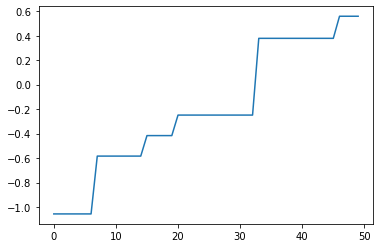

In [9]:
plt.plot(y_train[100,2,:])

Построение модели

In [10]:
# # without spectrogram
# class Autoencoder(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv1d(3, 32, kernel_size=7, stride=1, padding=3),
#             nn.BatchNorm1d(32),
#             nn.ReLU(),
#             nn.Conv1d(32, 64, kernel_size=7, stride=1, padding=3),
#             nn.BatchNorm1d(64),
#             nn.ReLU(),
#             nn.Conv1d(64, 16, kernel_size=7, stride=1, padding=3),
#             nn.BatchNorm1d(16),
#             nn.ReLU(),
#         )
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose1d(16, 16, kernel_size=7, stride=1, padding=3),
#             nn.BatchNorm1d(16),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.ConvTranspose1d(16, 32, kernel_size=7, stride=1, padding=3),
#             nn.BatchNorm1d(32),
#             nn.ReLU(),
#             nn.ConvTranspose1d(32, 3, kernel_size=7, stride=1, padding=3),
# #             nn.Linear
#         )
#     def forward(self, sample):
#         latent = self.encoder(sample)
#         reconstructed = self.decoder(latent)
#         return reconstructed

In [11]:
# with spectrogram
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(3,32, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 16, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(16),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(16, 16, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose1d(16, 32, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose1d(32, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU())
        self.FCN = nn.Sequential(
            nn.Linear(in_features=3200, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=50),
#             nn.ReLU(),
#             nn.Linear(in_features=128, out_features=50)
        )
#             nn.ReLU(),
#             nn.Linear(in_features=256, out_features=128),
#             nn.ReLU(),
#             nn.Linear(in_features=128, out_features=50),
    def forward(self, sample):
        latent = self.encoder(sample)
        x = self.decoder(latent)
        x = x.view(x.shape[0],-1)
#         print(x.shape)
        res = self.FCN(x)
        return res

Обучение

In [12]:
n_epochs = 100
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = F.mse_loss
train_losses = []
val_losses = []
i = 0
for epoch in tqdm.notebook.tqdm(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
#         print(i)
        reconstructed = model(X_batch.to(device))
        loss = loss_fn(reconstructed, Y_batch[:,2,:].to(device))
        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
        i+=1
    train_losses.append(np.mean(train_losses_per_epoch))

    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            reconstructed = model(X_batch.to(device))
            loss = loss_fn(reconstructed, Y_batch[:,2,:].to(device))
            val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))


  0%|          | 0/100 [00:00<?, ?it/s]

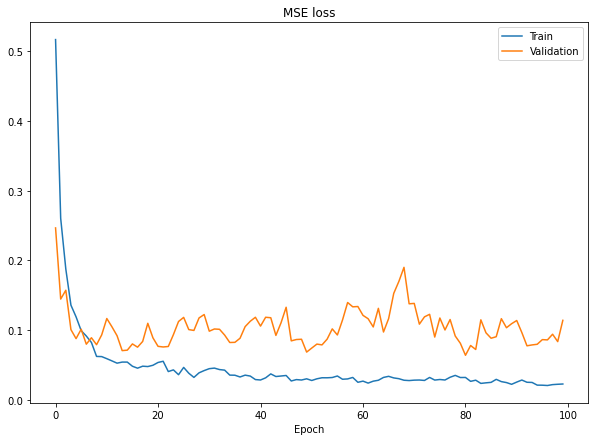

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

Посмотрим, как модель предсказывает траектории

In [14]:
test_loader = DataLoader(train_dataset, batch_size=20, shuffle=False)

model.eval()
x_pred = []
ground = []
losses = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        pred = model(x_batch.to(device)).cpu().numpy()
        x_pred.append(pred)
        ground.append(y_batch)      
        losses.append(np.mean(np.abs(pred - y_batch[:,2,:].numpy())))

torch.Size([20, 3, 50])


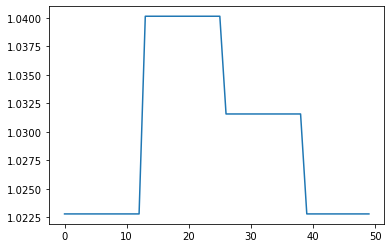

In [15]:
for x, y in test_loader:
    print(x.shape)
    plt.plot(x[0,2,:])
    break

In [16]:
gr = []
predict = []
for i in range(len(ground[0])):
    a =ground[1][i][2]
    b = x_pred[1][i]
    gr.append(a)
    predict.append(b)
gr = torch.stack(gr)
#print(gr)
gr = torch.ravel(gr)
pred = np.ravel(np.stack(predict))

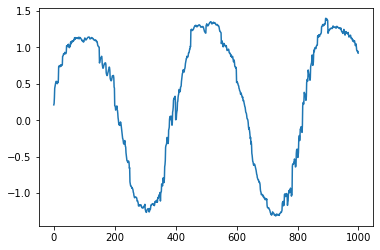

In [17]:
plt.plot(pred)

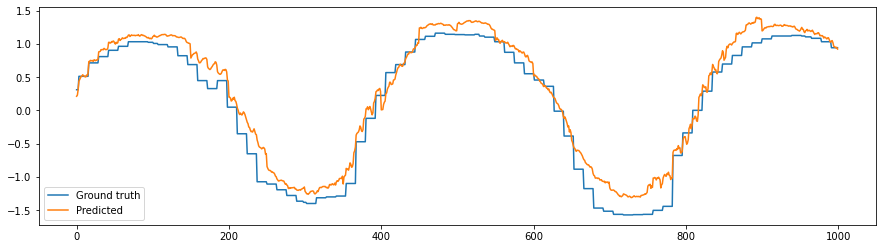

In [18]:
plt.figure(figsize=(15, 4))
predict = x_pred[0]
plt.plot(gr, label='Ground truth')
plt.plot(pred, label='Predicted')

plt.legend()
plt.show()